# h2o
Explicitly using h2o's deep learning. Standard scaling additionally carried out on certain features.

## Imports

In [3]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import KFold
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as acc
from scipy.stats import hmean 
from numpy import argmax
from sklearn.metrics import roc_auc_score as ras
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator 
from sklearn.preprocessing import StandardScaler as ss

## Reading Data
#### ...and some simple analysis.

In [104]:
df_test=pd.read_csv('test.csv')
df_train=pd.read_csv('train.csv')

In [105]:
#checking for null values
df_train.isnull().values.any()

False

In [106]:
df_train.shape

(31649, 18)

In [107]:
df_test.shape

(13562, 17)

In [108]:
df_test.head()

,serial_number,age_in_years,job_description,marital_status,education_details,has_default,balance_in_account,housing_status,previous_loan,phone_type,date,month_of_year,call_duration,campaign_contacts,days_passed,previous_contact,poutcome_of_campaign
0,1,33,admin.,married,secondary,no,796,yes,no,telephone,6,apr,216,1,-1,0,unknown
1,2,40,management,married,secondary,no,754,no,yes,cellular,6,apr,635,1,-1,0,unknown
2,3,30,technician,single,secondary,no,10152,yes,no,cellular,6,apr,1108,2,270,1,failure
3,4,44,blue-collar,married,secondary,no,545,yes,no,cellular,6,apr,122,3,136,1,failure
4,5,35,technician,married,secondary,no,5553,yes,no,cellular,6,apr,371,3,136,7,failure


In [109]:
df_train.head()

,serial_number,age_in_years,job_description,marital_status,education_details,has_default,balance_in_account,housing_status,previous_loan,phone_type,date,month_of_year,call_duration,campaign_contacts,days_passed,previous_contact,poutcome_of_campaign,outcome
0,1,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,2,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,3,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,4,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,5,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [110]:
for col in df_train:
    print(col,':',df_train[col].drop_duplicates().shape[0])

serial_number : 31649
age_in_years : 67
job_description : 12
marital_status : 3
education_details : 4
has_default : 2
balance_in_account : 6405
housing_status : 2
previous_loan : 2
phone_type : 3
date : 31
month_of_year : 11
call_duration : 1469
campaign_contacts : 48
days_passed : 243
previous_contact : 31
poutcome_of_campaign : 4
outcome : 2


In [111]:
#df_train.drop_duplicates(subset='previous_contact')['previous_contact']

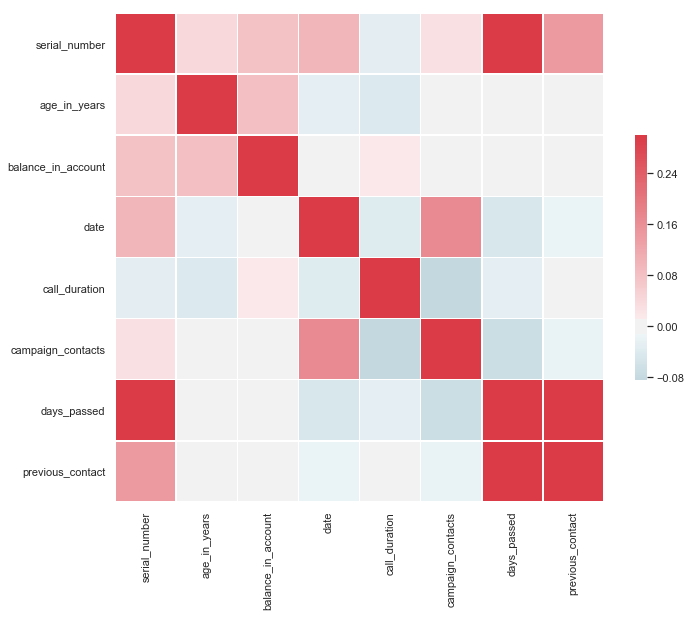

In [112]:
sns.set(style="white")
corr = df_train.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Feature Preprocessing

**Imputing**

In [113]:
dataset_new=df_train
test_final=df_test
def impute_unknowns(df, column):
    col_values = df[column].values
    df[column] = np.where(col_values=='unknown', df_train[column].mode(), col_values)
    return df
dataset_new = impute_unknowns(df=dataset_new, column='job_description')
dataset_new = impute_unknowns(df=dataset_new, column='education_details')
test_final = impute_unknowns(df=df_test, column='job_description')
test_final = impute_unknowns(df=test_final, column='education_details')

**Scaling**

To scale: Age, Balance, Call Duration, days passed.

In [115]:
scaled_train = pd.DataFrame(dataset_new).copy()

col_names = ['age_in_years', 'balance_in_account', 'call_duration', 'days_passed']
features = scaled_train[col_names]
scaler = ss().fit(features.values)
features = scaler.transform(features.values)

scaled_train[col_names] = features

scaled_train.head() 




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,serial_number,age_in_years,job_description,marital_status,education_details,has_default,balance_in_account,housing_status,previous_loan,phone_type,date,month_of_year,call_duration,campaign_contacts,days_passed,previous_contact,poutcome_of_campaign,outcome
0,1,1.759644,management,married,tertiary,no,0.286923,yes,no,unknown,5,may,0.032751,1,-0.245808,0,unknown,no
1,2,0.300930,technician,single,secondary,no,-0.426992,yes,no,unknown,5,may,-0.386551,1,-0.245808,0,unknown,no
2,3,-0.845201,entrepreneur,married,secondary,no,-0.436110,yes,yes,unknown,5,may,-0.672439,1,-0.245808,0,unknown,no
3,4,0.613512,blue-collar,married,secondary,no,0.071803,yes,no,unknown,5,may,-0.611450,1,-0.245808,0,unknown,no
4,5,-0.845201,blue-collar,single,secondary,no,-0.436448,no,no,unknown,5,may,-0.207395,1,-0.245808,0,unknown,no


In [116]:
scaled_test = pd.DataFrame(test_final).copy()

col_names = ['age_in_years', 'balance_in_account', 'call_duration', 'days_passed']
features = scaled_test[col_names]
scaler = ss().fit(features.values)
features = scaler.transform(features.values)

scaled_test[col_names] = features

scaled_test.head() 




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,serial_number,age_in_years,job_description,marital_status,education_details,has_default,balance_in_account,housing_status,previous_loan,phone_type,date,month_of_year,call_duration,campaign_contacts,days_passed,previous_contact,poutcome_of_campaign
0,1,-0.593734,admin.,married,secondary,no,-0.225389,yes,no,telephone,6,apr,-0.226544,1,-0.751832,0,unknown
1,2,-0.041526,management,married,secondary,no,-0.238410,no,yes,cellular,6,apr,1.480904,1,-0.751832,0,unknown
2,3,-0.830394,technician,single,secondary,no,2.675073,yes,no,cellular,6,apr,3.408405,2,1.104533,1,failure
3,4,0.274022,blue-collar,married,secondary,no,-0.303202,yes,no,cellular,6,apr,-0.609600,3,0.186625,1,failure
4,5,-0.435960,technician,married,secondary,no,1.249333,yes,no,cellular,6,apr,0.405089,3,0.186625,7,failure


## Data separation

In [117]:
frame_sno = scaled_test['serial_number'] #serial numbers
frame_train_target = pd.DataFrame(scaled_train['outcome']) #Y of train
frame_train = scaled_train.drop(['outcome','serial_number'], axis = 1) #X array of train
frame_test = scaled_test.drop(['serial_number'], axis = 1) #testdata array
frame_test.shape

(13562, 16)

## Adopting Ninjarao's Encoding

### Target Variable

In [118]:
encoder= LabelEncoder()
dataset_encoded= encoder.fit_transform(frame_train_target['outcome'])
dataset_encoded
frame_train_target['outcome']=dataset_encoded


In [119]:
frame_train_target.drop_duplicates()

,outcome
0,0
83,1


### Binary features

In [120]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in frame_train:
    if frame_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(frame_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(frame_train[col])
            # Transform both training and testing data
            frame_train[col] = le.transform(frame_train[col])
            frame_test[col] = le.transform(frame_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)


3 columns were label encoded.


### One hot for other categoricals

In [121]:
frame_train = pd.get_dummies(frame_train)#One hot encoding(Prolly better ways of doing this)
frame_test = pd.get_dummies(frame_test)

train_labels = frame_train_target
# Align the training and testing data, keep only columns present in both dataframes
frame_train, frame_test = frame_train.align(frame_test, join = 'inner', axis = 1)

# Add the target back in
frame_train['outcome'] = train_labels

print('Training Features shape: ', frame_train.shape)
print('Testing Features shape: ', frame_test.shape)


Training Features shape:  (31649, 46)
Testing Features shape:  (13562, 45)


### Viewing

In [122]:
#frame_train

## Conversion into arrays 

In [123]:
sno = frame_sno.values 
#train_target = frame_train_target.values
#train = np.array(frame_train) 
#test = np.array(frame_test) 
#frame_train.shape

## DL
#### Initialization

In [124]:
h2o.init()
#from h2o.automl import H2OAutoML

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,45 mins 38 secs
H2O cluster timezone:,Asia/Muscat
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_Chinmayan_f4883o
H2O cluster total nodes:,1
H2O cluster free memory:,3.302 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


#### Preparing Data

In [125]:
hT = h2o.H2OFrame(frame_train)
x = hT.columns
y ='outcome'
x.remove(y)
hT['outcome'] = hT['outcome'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Deep Learning

In [129]:
dl_fit1 = H2ODeepLearningEstimator(model_id='dl_fit1',   seed=1,  balance_classes = True)
dl_fit1.train(x=x, y=y, training_frame=hT)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [22]:
dl_fit2 = H2ODeepLearningEstimator(nfolds=10, model_id='dl_fit2', 
                                   epochs=50, 
                                   hidden=[10,10], 
                                   stopping_rounds=0,  #disable early stopping
                                   seed=1,
                                   balance_classes = True)
dl_fit2.train(x=x, y=y, training_frame=hT)



deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [23]:
dl_fit3 = H2ODeepLearningEstimator(nfolds=10, model_id='dl_fit3', 
                                   epochs=500, 
                                   hidden=[10,10],
                                   score_interval=1,          #used for early stopping
                                   stopping_rounds=50,         #used for early stopping
                                   stopping_metric='AUC',     #used for early stopping
                                   stopping_tolerance=0.0005, #used for early stopping
                                   seed=1,  
                                   balance_classes = True)
dl_fit3.train(x=x, y=y, training_frame=hT)



deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [130]:
dl_perf1 = dl_fit1.model_performance(hT)

In [ ]:
dl_perf2 = dl_fit2.model_performance(hT)

In [ ]:
dl_perf3 = dl_fit3.model_performance(hT)

In [131]:
dl_perf1


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.0251934529536905
RMSE: 0.15872445606676527
LogLoss: 0.08146508596361557
Mean Per-Class Error: 0.046268197378381504
AUC: 0.9849239615406494
pr_auc: 0.7588733208300638
Gini: 0.9698479230812989
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16545970230021192: 


,0,1,Error,Rate
0,29048.0,761.0,0.0255,(761.0/29809.0)
1,323.0,1517.0,0.1755,(323.0/1840.0)
Total,29371.0,2278.0,0.0343,(1084.0/31649.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1654597,0.7367654,295.0
max f2,0.0484389,0.8253174,350.0
max f0point5,0.3844607,0.7278870,212.0
max accuracy,0.2960794,0.9679295,242.0
max precision,0.9813502,0.92,6.0
max recall,0.0000024,1.0,399.0
max specificity,0.9991670,0.9999329,0.0
max absolute_mcc,0.1267844,0.7258957,312.0
max min_per_class_accuracy,0.0319187,0.9494565,360.0
max mean_per_class_accuracy,0.0081302,0.9537318,382.0


Gains/Lift Table: Avg response rate:  5.81 %, avg score:  4.27 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100161,0.8549692,15.2471695,15.2471695,0.8864353,0.9263124,0.8864353,0.9263124,0.1527174,0.1527174,1424.7169455,1424.7169455
,2,0.0200006,0.7380291,13.5535928,14.4017189,0.7879747,0.7937513,0.8372828,0.8601366,0.1353261,0.2880435,1255.3592804,1340.1718868
,3,0.0300167,0.6106610,12.5884104,13.7966465,0.7318612,0.6737283,0.8021053,0.7979351,0.1260870,0.4141304,1158.8410369,1279.6646453
,4,0.0400013,0.4927585,11.8661977,13.3147967,0.6898734,0.5541335,0.7740916,0.7370810,0.1184783,0.5326087,1086.6197716,1231.4796689
,5,0.0500174,0.3794568,11.3404214,12.9194227,0.6593060,0.4327313,0.7511055,0.6761341,0.1135870,0.6461957,1034.0421410,1191.9422739
,6,0.1000032,0.0357582,5.9473434,9.4344845,0.3457649,0.1637252,0.5484992,0.4200106,0.2972826,0.9434783,494.7343415,843.4484511
,7,0.1500205,0.0024251,0.9453236,6.6041682,0.0549589,0.0120450,0.3839511,0.2839935,0.0472826,0.9907609,-5.4676385,560.4168231
,8,0.2000063,0.0001958,0.1304719,4.9862555,0.0075853,0.0008922,0.2898894,0.2132405,0.0065217,0.9972826,-86.9528115,398.6255495
,9,0.3000095,0.0000016,0.0271731,3.3332280,0.0015798,0.0000394,0.1937862,0.1421735,0.0027174,1.0,-97.2826946,233.3228015
,10,0.4000126,0.0000000,0.0,2.4999210,0.0,0.0000003,0.1453397,0.1066302,0.0,1.0,-100.0,149.9921011


In [26]:
dl_perf2


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.03697927441575632
RMSE: 0.19229995947934134
LogLoss: 0.12421078972353047
Mean Per-Class Error: 0.09282504408502246
AUC: 0.9535631199798136
pr_auc: 0.4871232793374255
Gini: 0.9071262399596272
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20407764567476583: 


,0,1,Error,Rate
0,27919.0,1890.0,0.0634,(1890.0/29809.0)
1,458.0,1382.0,0.2489,(458.0/1840.0)
Total,28377.0,3272.0,0.0742,(2348.0/31649.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2040776,0.5406886,263.0
max f2,0.0797959,0.6861020,333.0
max f0point5,0.3583456,0.5103990,180.0
max accuracy,0.4523026,0.9462858,130.0
max precision,0.9539017,0.6666667,2.0
max recall,0.0000026,1.0,399.0
max specificity,0.9704928,0.9999665,0.0
max absolute_mcc,0.1616969,0.5373656,287.0
max min_per_class_accuracy,0.0686225,0.8970445,340.0
max mean_per_class_accuracy,0.0060344,0.9071750,386.0


Gains/Lift Table: Avg response rate:  5.81 %, avg score:  4.89 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100161,0.5835052,10.6350363,10.6350363,0.6182965,0.6696724,0.6182965,0.6696724,0.1065217,0.1065217,963.5036346,963.5036346
,2,0.0200006,0.5198804,9.3078890,9.9725110,0.5411392,0.5496291,0.5797788,0.6097455,0.0929348,0.1994565,830.7889034,897.2510990
,3,0.0300167,0.4722987,9.2785266,9.7409394,0.5394322,0.4942425,0.5663158,0.5712040,0.0929348,0.2923913,827.8526608,874.0939359
,4,0.0400013,0.4310979,8.5458396,9.4426364,0.4968354,0.4513435,0.5489731,0.5412862,0.0853261,0.3777174,754.5839640,844.2636428
,5,0.0500174,0.3938220,7.1623714,8.9860072,0.4164038,0.4123147,0.5224258,0.5154593,0.0717391,0.4494565,616.2371417,798.6007237
,6,0.1000032,0.2157525,5.6102910,7.2986824,0.3261694,0.3033284,0.4243286,0.4094274,0.2804348,0.7298913,461.0291046,629.8682430
,7,0.1500205,0.0654983,3.3683945,5.9883105,0.1958307,0.1365083,0.3481466,0.3184352,0.1684783,0.8983696,236.8394490,498.8310524
,8,0.2000063,0.0030752,1.3047188,4.8177826,0.0758534,0.0217674,0.2800948,0.2442917,0.0652174,0.9635870,30.4718848,381.7782557
,9,0.3000095,0.0000077,0.3423805,3.3259819,0.0199052,0.0005141,0.1933649,0.1630325,0.0342391,0.9978261,-65.7619514,232.5981867
,10,0.4000126,0.0000000,0.0163038,2.4985624,0.0009479,0.0000012,0.1452607,0.1222746,0.0016304,0.9994565,-98.3696167,149.8562358


In [27]:
dl_perf3


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.03756331349769859
RMSE: 0.1938125731156227
LogLoss: 0.12257274115720845
Mean Per-Class Error: 0.08006712482515499
AUC: 0.9595172598879533
pr_auc: 0.5016387825776021
Gini: 0.9190345197759067
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22521443255883844: 


,0,1,Error,Rate
0,27929.0,1880.0,0.0631,(1880.0/29809.0)
1,355.0,1485.0,0.1929,(355.0/1840.0)
Total,28284.0,3365.0,0.0706,(2235.0/31649.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2252144,0.5706052,256.0
max f2,0.1376521,0.7149700,297.0
max f0point5,0.5093547,0.5255896,140.0
max accuracy,0.5749890,0.9470757,115.0
max precision,0.9992351,0.7272727,0.0
max recall,0.0000034,1.0,399.0
max specificity,0.9992351,0.9997987,0.0
max absolute_mcc,0.1721192,0.5664406,281.0
max min_per_class_accuracy,0.1155488,0.9093227,309.0
max mean_per_class_accuracy,0.0592297,0.9199329,341.0


Gains/Lift Table: Avg response rate:  5.81 %, avg score:  6.62 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100161,0.9390714,10.1466928,10.1466928,0.5899054,0.9727567,0.5899054,0.9727567,0.1016304,0.1016304,914.6692840,914.6692840
,2,0.0200006,0.7567317,9.4711853,9.8094727,0.5506329,0.8474689,0.5703002,0.9102118,0.0945652,0.1961957,847.1185333,880.9472663
,3,0.0300167,0.6342292,9.7126097,9.7771510,0.5646688,0.6891489,0.5684211,0.8364466,0.0972826,0.2934783,871.2609724,877.7151030
,4,0.0400013,0.5559382,9.3623211,9.6736074,0.5443038,0.5922905,0.5624013,0.7755040,0.0934783,0.3869565,836.2321134,867.3607391
,5,0.0500174,0.4998304,7.7592357,9.2902493,0.4511041,0.5276439,0.5401137,0.7258693,0.0777174,0.4646739,675.9235702,829.0249320
,6,0.1000032,0.2543076,6.1213059,7.7062782,0.3558786,0.3746831,0.4480253,0.5503317,0.3059783,0.7706522,512.1305928,670.6278247
,7,0.1500205,0.0890922,3.2706024,6.2274082,0.1901453,0.1590490,0.3620472,0.4198766,0.1635870,0.9342391,227.0602392,522.7408222
,8,0.2000063,0.0255334,0.9241759,4.9020190,0.0537295,0.0512474,0.2849921,0.3277484,0.0461957,0.9804348,-7.5824149,390.2019026
,9,0.3000095,0.0002495,0.1576037,3.3205473,0.0091627,0.0069533,0.1930490,0.2208167,0.0157609,0.9961957,-84.2396284,232.0547256
,10,0.4000126,0.0000000,0.0271731,2.4972037,0.0015798,0.0000271,0.1451817,0.1656193,0.0027174,0.9989130,-97.2826946,149.7203706


The first model has much lower logloss compared to the other two, so we'll go with that and hope we're not overfitting.

In [59]:
preds = dl_fit1.predict(h2o.H2OFrame(frame_test))
preds = preds.as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


## Preparing the submission

##### Decoding

In [60]:
outcomes=preds['predict']
outcomes.head()

0    0
1    0
2    0
3    1
4    0
Name: predict, dtype: int64

In [61]:

sub=pd.DataFrame({'outcome':outcomes})


In [62]:
sub[sub['outcome']==1.0]='yes'
sub[sub['outcome']==0.0]='no'
sub.drop_duplicates()

,outcome
0,no
3,yes


In [63]:
sub[sub['outcome']=='no'].shape[0]/sub.shape[0] #percentage of no

0.8392567467925085

In [64]:
sub['serial_number']=sno
sub=sub[['serial_number','outcome']]

In [65]:
sub.head()

,serial_number,outcome
0,1,no
1,2,no
2,3,no
3,4,yes
4,5,no


In [66]:
sub.to_csv("sub_dl_prep_scaled.csv", index=False)